In [17]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [2]:
seeders = [123456, 789012, 345678, 901234, 567890, 123, 456, 789, 123, 456]

seed = seeders[0]

np.random.seed(seed)
random.seed(seed)

In [3]:
root_path = os.path.join('..', '..')

In [4]:
dataset = pd.read_csv(os.path.join(root_path, 'data', 'train.csv'))


In [5]:
data = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())
print(len(data))

    index Access Gained Attack Origin Authentication Required Availability  \
0   22328           NaN         Local            Not required     Complete   
1   39415           NaN         Local            Not required          NaN   
2   60861           NaN        Remote           Single system          NaN   
3   84364           NaN         Local            Not required      Partial   
4  177580           NaN        Remote            Not required     Complete   

           CVE ID                                        CVE Page   CWE ID  \
0   CVE-2011-4621   https://www.cvedetails.com/cve/CVE-2011-4621/      NaN   
1   CVE-2014-1738   https://www.cvedetails.com/cve/CVE-2014-1738/  CWE-264   
2  CVE-2017-14604  https://www.cvedetails.com/cve/CVE-2017-14604/   CWE-20   
3   CVE-2018-6560   https://www.cvedetails.com/cve/CVE-2018-6560/  CWE-436   
4   CVE-2016-1621   https://www.cvedetails.com/cve/CVE-2016-1621/  CWE-119   

  Complexity Confidentiality  ... parentID  \
0        Low    

In [6]:
data = data[data["project"] != "Chrome"]
print(len(data))

89145


In [7]:
data = data[["processed_func", "target"]]
data.head()

,processed_func,target
0,void account_system_time(struct task_struct *p...,0
1,static void redo_fd_request(void)\n{\n\tint dr...,0
2,cancel_filesystem_info_for_file (NautilusDirec...,0
3,"buffer_write (ProxySide *side,\n ...",0
4,virtual ~Trans16x16DCT() {}\n,0


In [8]:
data = data.dropna(subset=["processed_func"])

In [9]:
word_counts = data["processed_func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

Maximum number of words: 15441


In [10]:
vc = data["target"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

target
0    83578
1     5567
Name: count, dtype: int64
Percentage:  6.660843762712676 %
2


In [11]:
train_data = pd.DataFrame(({'text': data['processed_func'], 'label': data['target']}))
#train_data = train_data[0:100]
train_data.head()

,text,label
0,void account_system_time(struct task_struct *p...,0
1,static void redo_fd_request(void)\n{\n\tint dr...,0
2,cancel_filesystem_info_for_file (NautilusDirec...,0
3,"buffer_write (ProxySide *side,\n ...",0
4,virtual ~Trans16x16DCT() {}\n,0


In [12]:
val_data = pd.read_csv(os.path.join(root_path, 'data', 'val.csv'))

val_data = val_data[val_data["project"] != "Chrome"]

val_data = pd.DataFrame(({'text': val_data['processed_func'], 'label': val_data['target']}))
val_data.head()

,text,label
1,int iwlagn_add_bssid_station(struct iwl_priv *...,0
2,"static int dnxhd_init_vlc(DNXHDContext *ctx, u...",0
3,void CameraService::onFirstRef()\n{\n LOG1(...,0
4,int EmbedStream::getChar() {\n if (limited &&...,0
5,"json_t *json_rpc_call(CURL *curl, const char *...",0


In [13]:
test_data = pd.read_csv(os.path.join(root_path, 'data', 'test.csv'))

test_data = test_data[test_data["project"] != "Chrome"]

test_data = pd.DataFrame(({'text': test_data['processed_func'], 'label': test_data['target']}))

In [18]:
sampling = False
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["label"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = 2 * class_counts[class_counts.idxmin()] # class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2) 
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["text"]).reshape(-1, 1), train_data["label"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["text"]
    Y_train = train_data["label"]

Class distribution  label
0    83578
1     5567
Name: count, dtype: int64
Majority class  0
Minority class  1
Targeted number of majority class 11134
Class distribution after augmentation label
0    11134
1     5567
Name: count, dtype: int64


In [19]:
# textual code data
X_val = val_data["text"]

X_test = test_data["text"]

In [20]:
# labels
y_train = Y_train
y_val = val_data["label"]
y_test = test_data["label"]

In [21]:
# apply BoW feature extraction
vectorizer = TfidfVectorizer(norm='l2', max_features=1000)
vectorizer = vectorizer.fit(X_train)

In [22]:
X_train = np.asarray(vectorizer.transform(X_train).todense())
X_val = np.asarray(vectorizer.transform(X_val).todense())
X_test = np.asarray(vectorizer.transform(X_test).todense())

In [24]:
# define model
myModel = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            verbose=1)

# myModel = SVC(kernel='rbf', gamma=100)
# myModel = tree.DecisionTreeClassifier(max_depth=120)
# myModel = GaussianNB()
# myModel = KNeighborsClassifier(n_neighbors=1)

In [25]:
# train model
myModel.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)

In [26]:
# make predictions
val_preds = myModel.predict(X_val)
preds = myModel.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    1.5s finished


In [28]:
# evaluate on validation data
f1 = f1_score(y_true=y_val, y_pred=val_preds)
precision = precision_score(y_true=y_val, y_pred=val_preds)
recall = recall_score(y_true=y_val, y_pred=val_preds)
f2 = 5*precision*recall / (4*precision+recall)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F2 Score: {f2}")

F1 Score: 0.3699481865284974
Precision: 0.28836833602584816
Recall: 0.5158959537572254
F2 Score: 0.445581627558662


F1 Score: 0.33935018050541516
Precision: 0.26596604688763137
Recall: 0.4686609686609687
F2 Score: 0.40667490729295425
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     10492
           1       0.27      0.47      0.34       702

    accuracy                           0.89     11194
   macro avg       0.61      0.69      0.64     11194
weighted avg       0.92      0.89      0.90     11194



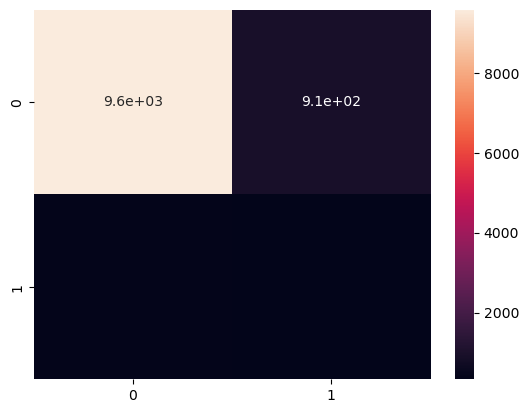

In [29]:
# evaluate on test data
f1 = f1_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
recall = recall_score(y_true=y_test, y_pred=preds)
f2 = 5*precision*recall / (4*precision+recall)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F2 Score: {f2}")

cm = confusion_matrix(y_test, preds)
#print(cm)
sn.heatmap(cm, annot=True)
print(classification_report(y_test, preds))